# Implementation of MAXSER

## Step 0: Subpool selection
   1. Form 1000 random subpools of 12 assets
   2. Calculate the adjusted Sharpe ratio, $\hat{\theta}_{adj}$: $$\hat{\theta}_{adj} = \frac{(T-N-2)\hat{\theta}_s-N}{T}+\frac{2(\hat{\theta}_s)^{N/2}(1+\hat{\theta}_s)^{-(T-2)/2}}{TB_{\hat{\theta}_s/(1+\hat{\theta}_s)}(N/2,(T-N)/2)}$$
      where $\hat{\theta}_s$ is the sample estimate of the Sharpe ratio $$\hat{\theta}_s:=\mathbf{\hat{\mu}}'\mathbf{\hat{\Sigma}}^{-1}\mathbf{\hat{\mu}}$$
      and $$B_x(a,b) = \int_0^x y^{a-1}(1-y)^{b-1}dy$$
   3. Select the subpool with $\hat{\theta}_{adj}$ corresponding to 95th percentile.

## Step 1 
   1. Estimate the square of the maximum Sharpe ratio by $\hat{\theta}_{adj}$
   2. Compute response $$\hat{r}_c := \sigma\frac{1+\hat{\theta}}{\sqrt{\hat{\theta}}}$$
   where $\sigma$ is a given risk constraint (i.e. target risk level), and $$\hat{\theta}:=\frac{(T-N-2)\hat{\theta}_s-N}{T}$$

## Step 2
   1. Split the sample into 10 random groups and select $\lambda$ through 10-fold cross-validation:
      - For each training set $i$, obtain the whole solution path $(\mathbf{\omega}_{0≤\zeta≤1})$ (using LARS?)
      - Calculate the difference between the risk computed using the validation set and the given risk constraint
      - $\hat{\zeta}$ is taken to be the average of $\zeta(i), i = 1,\dots,10$
      - Denote selected value by $\hat{\lambda}$
   
## Step 3
   1. Use the estimated $\hat{\lambda}$ in $$\hat{\mathbf{\omega^*}} = \underset{\mathbf{\omega}}{\mathrm{argmin}}\frac{1}{T}\sum_{t=1}^T(\hat{r}_c-\mathbf{\omega}'\mathbf{R_t})^2\quad \text{subect to} \quad ||\mathbf{\omega}||_1≤\hat{\lambda}$$ and solve for the MAXSER portfolio weights $\hat{\mathbf{\omega^*}}$

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import betainc
from scipy.stats import beta
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

data = pd.read_csv('48_Industry_Portfolios.csv', skiprows=11, nrows=1181, index_col=0)
data.index = pd.to_datetime(data.index, format='%Y%m')
data = data.iloc[-60:]      # use last 60 observations (5 years)

rf_data = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, nrows=1181, index_col=0)
rf_data.index = pd.to_datetime(rf_data.index, format='%Y%m')
rf_data.tail()

,Mkt-RF,SMB,HML,RF
2024-07-01,1.24,6.80,5.74,0.45
2024-08-01,1.61,-3.55,-1.13,0.48
2024-09-01,1.74,-0.17,-2.59,0.40
2024-10-01,-0.97,-1.01,0.89,0.39
2024-11-01,6.50,4.63,-0.05,0.40


In [261]:
rf = 0.40                       # most recent risk free rate from factor dataset
data_excess = data - rf         # compute excess returns
data_excess = data_excess / 100 # convert to percentage
T, N = data.shape
data_excess.head()

# compute each sharpe ratio
sharpe = data_excess.mean() / data_excess.std()
sharpe

Agric    0.192638
Food     0.023379
Soda     0.084019
Beer     0.025924
Smoke    0.156046
Toys    -0.069445
Fun      0.110135
Books    0.109205
Hshld    0.060126
Clths    0.008901
Hlth     0.013568
MedEq    0.060336
Drugs    0.116737
Chems    0.060590
Rubbr    0.136961
Txtls    0.026528
BldMt    0.199358
Cnstr    0.232949
Steel    0.173437
FabPr    0.136855
Mach     0.186292
ElcEq    0.087409
Autos    0.213482
Aero     0.045103
Ships    0.134813
Guns     0.161916
Gold     0.054184
Mines    0.197914
Coal     0.224998
Oil      0.130566
Util     0.111191
Telcm   -0.012795
PerSv    0.118173
BusSv    0.186104
Comps    0.195017
Chips    0.300243
LabEq    0.107919
Paper   -0.017160
Boxes    0.078141
Trans    0.107313
Whlsl    0.196245
Rtail    0.179052
Meals    0.111674
Banks    0.103027
Insur    0.176108
RlEst    0.103167
Fin      0.203168
Other    0.177963
dtype: float64

In [262]:
# Derive a sigma value
cov_matrix = data_excess.cov()
weights = np.full(N, 1 / N)  # naive weights for all assets

var = np.dot(weights.T, np.dot(cov_matrix, weights))
sigma = np.sqrt(var).round(2)
print(sigma)

p_ret = np.dot(weights, data_excess.mean())
print(p_ret)
# Calculate the Sharpe ratio
p_sharpe = p_ret / sigma

print(p_sharpe) # for comparison


0.06
0.00943704861111111
0.1572841435185185


In [263]:
# Step 0: Subpool Selection
num_pools = 1000
pool_size = 12

def adjusted_sharpe_ratio(theta_s, T, N):
    # Calculate the incomplete beta function B_x(a, b)
    x = (theta_s) / (1 + theta_s)
    a = N / 2
    b = (T - N) / 2
    B = betainc(a, b, x)
    
    theta_adj = ((T - N - 2) * theta_s - N) / T + ((2 * (theta_s ** (N / 2)) * ((1 + theta_s) ** (-(T - 2) / 2))) / (T * B))
    
    return theta_adj

def subpool_selection(data, num_pools, pool_size):
    np.random.seed(60202)
    subpool_sharpes = []
    for _ in range(num_pools):
        subpool_indices = np.random.choice(N, pool_size, replace=False)
        subpool = data.iloc[:, subpool_indices]
        mu = subpool.mean(axis=0)
        cov = subpool.cov()
        theta_s = np.dot(mu.T, np.linalg.solve(cov, mu))
        theta_adj = adjusted_sharpe_ratio(theta_s, T, pool_size)
        subpool_sharpes.append((theta_adj, subpool_indices))

    subpool_sharpes.sort(reverse=True, key=lambda x: x[0])
    percentile_index = int(0.95 * len(subpool_sharpes)) - 1
    return subpool_sharpes[percentile_index][0], subpool_sharpes[percentile_index][1]  

best_theta_adj, best_subpool_indices = subpool_selection(data_excess, num_pools, pool_size)
print(best_theta_adj, best_subpool_indices)
print(T, N)

test_adj = adjusted_sharpe_ratio(p_sharpe, T, 48)
print(test_adj)

-0.08814822792384343 [34 14 18 20 22 40  8  4 39 29  0 12]
60 48
-0.7737857041548631


In [264]:
# Step 1: Calculate adjusted Sharpe ratio and response
def calculate_response(data, sigma, subpool_indices):
    mu = data.mean(axis=0)
    cov = data.cov()
    theta_s = np.dot(mu[subpool_indices].T, np.linalg.solve(cov.iloc[subpool_indices, subpool_indices], mu[subpool_indices]))
    theta_hat = ((T - pool_size - 2) * theta_s - pool_size) / T  # Use pool_size instead of N
    theta_hat = np.abs(theta_hat)  # Use absolute value to ensure positive value for sqrt
    response = sigma * (1 + theta_hat) / np.sqrt(theta_hat)
    return response

response = calculate_response(data_excess, sigma, best_subpool_indices)
print(f"Response value: {response:.4f}")

Response value: 0.2199


/var/folders/c5/0k9q6ymj10d7tsm7thk3_yqr0000gn/T/ipykernel_99080/411927598.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta_s = np.dot(mu[subpool_indices].T, np.linalg.solve(cov.iloc[subpool_indices, subpool_indices], mu[subpool_indices]))


In [265]:
# Step 2: Cross-validation to select lambda
kf = KFold(n_splits=10, shuffle=True, random_state=42)
def select_lambda(data, response):
    X = data.values
    y = np.full(X.shape[0], response)

    lasso = LassoCV(cv=kf, max_iter=10000).fit(X, y)
    return lasso.alpha_

lambda_hat = select_lambda(data_excess, response)
print(lambda_hat)

1e-15


MAXSER Portfolio Weights:
Agric    1.022361e-05
Food    -2.272107e-06
Soda     7.716924e-06
Beer     1.171240e-06
Smoke    7.728532e-06
Toys    -5.849009e-08
Fun      3.048657e-06
Books    7.709848e-07
Hshld   -3.972020e-06
Clths    3.410623e-06
Hlth    -2.885348e-06
MedEq    2.819066e-06
Drugs    1.471453e-05
Chems    2.213541e-07
Rubbr   -1.922199e-06
Txtls    7.237982e-06
BldMt    1.337888e-07
Cnstr    7.693238e-07
Steel   -2.211511e-06
FabPr    4.891833e-07
Mach     9.055290e-06
ElcEq    2.049023e-06
Autos    4.755208e-03
Aero    -1.513385e-06
Ships    8.105153e-08
Guns     1.563899e-05
Gold     1.744180e-06
Mines   -8.883707e-06
Coal     1.491821e-06
Oil      3.169411e-07
Util     4.668597e-06
Telcm    5.220769e-07
PerSv    2.317114e-06
BusSv    1.712004e-06
Comps   -1.007540e-06
Chips   -6.068367e-07
LabEq    1.509853e-06
Paper   -4.260285e-06
Boxes   -3.621509e-06
Trans   -9.580630e-07
Whlsl   -2.636202e-07
Rtail    6.809554e-06
Meals    2.341937e-06
Banks   -1.879666e-06
Insur 

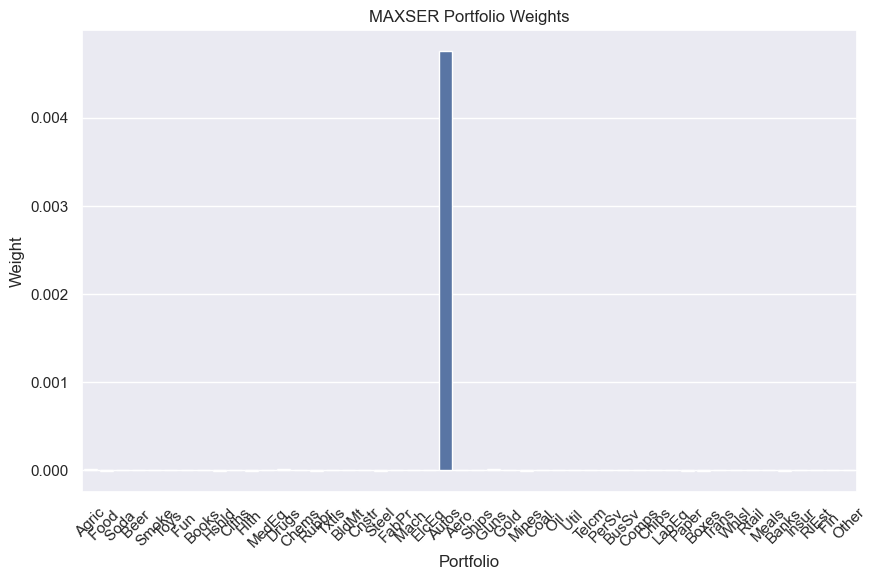

In [266]:
# Step 3: Solve for MAXSER portfolio weights
def maxser_weights(data, response, lambda_val):
    from scipy.optimize import minimize

    X = data.values
    y = np.full(X.shape[0], response)

    def loss_fn(weights):
        return np.mean((y - X @ weights) ** 2)

    constraints = ({'type': 'ineq', 'fun': lambda w: lambda_val - np.sum(np.abs(w))})
    # bounds = [(0, None)] * data.shape[1]
    bounds = [(None, None)] * data.shape[1]

    result = minimize(loss_fn, np.ones(data.shape[1]) / data.shape[1], bounds=bounds, constraints=constraints)
    return result.x

weights = maxser_weights(data_excess, response, lambda_hat)

# Final portfolio weights
portfolio_weights = pd.Series(weights, index=data_excess.columns)
print("MAXSER Portfolio Weights:")
print(portfolio_weights)

#sum portfolio weights
print("Sum of Portfolio Weights:")
print(portfolio_weights.sum())

# visualize portfolio weights

sns.set()

plt.figure(figsize=(10, 6))
sns.barplot(x=portfolio_weights.index, y=portfolio_weights.values)
plt.xticks(rotation=45)
plt.title("MAXSER Portfolio Weights")
plt.xlabel("Portfolio")
plt.ylabel("Weight")
plt.show()